Loading audio and extracting features...


/home/muzykos-laptop/Documents/GIThub/Projekt_badawczy_System_rozpoznawania_zdarzen_dzwiekowych_w_przestrzeni_domowej-main/.venv/lib/python3.13/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Evaluating models for n_mfcc from 1 to 50...
n_mfcc=5: Accuracy=0.6061
n_mfcc=10: Accuracy=0.6494
n_mfcc=15: Accuracy=0.6840
n_mfcc=20: Accuracy=0.7013
n_mfcc=25: Accuracy=0.6840
n_mfcc=30: Accuracy=0.6883
n_mfcc=35: Accuracy=0.7013
n_mfcc=40: Accuracy=0.7186
n_mfcc=45: Accuracy=0.7056
n_mfcc=50: Accuracy=0.7100
n_mfcc=55: Accuracy=0.7056
n_mfcc=60: Accuracy=0.7013
n_mfcc=65: Accuracy=0.7013
n_mfcc=70: Accuracy=0.6926
n_mfcc=75: Accuracy=0.7056
n_mfcc=80: Accuracy=0.6970
n_mfcc=85: Accuracy=0.6926
n_mfcc=90: Accuracy=0.6970
n_mfcc=95: Accuracy=0.7316
n_mfcc=100: Accuracy=0.7403
n_mfcc=105: Accuracy=0.7446
n_mfcc=110: Accuracy=0.7489
n_mfcc=115: Accuracy=0.7489
n_mfcc=120: Accuracy=0.7489
n_mfcc=125: Accuracy=0.7489
n_mfcc=130: Accuracy=0.7446
n_mfcc=135: Accuracy=0.7446
n_mfcc=140: Accuracy=0.7446
n_mfcc=145: Accuracy=0.7446
n_mfcc=150: Accuracy=0.7446
n_mfcc=155: Accuracy=0.7446
n_mfcc=160: Accuracy=0.7446
n_mfcc=165: Accuracy=0.7446
n_mfcc=170: Accuracy=0.7446
n_mfcc=175: Accuracy=0.

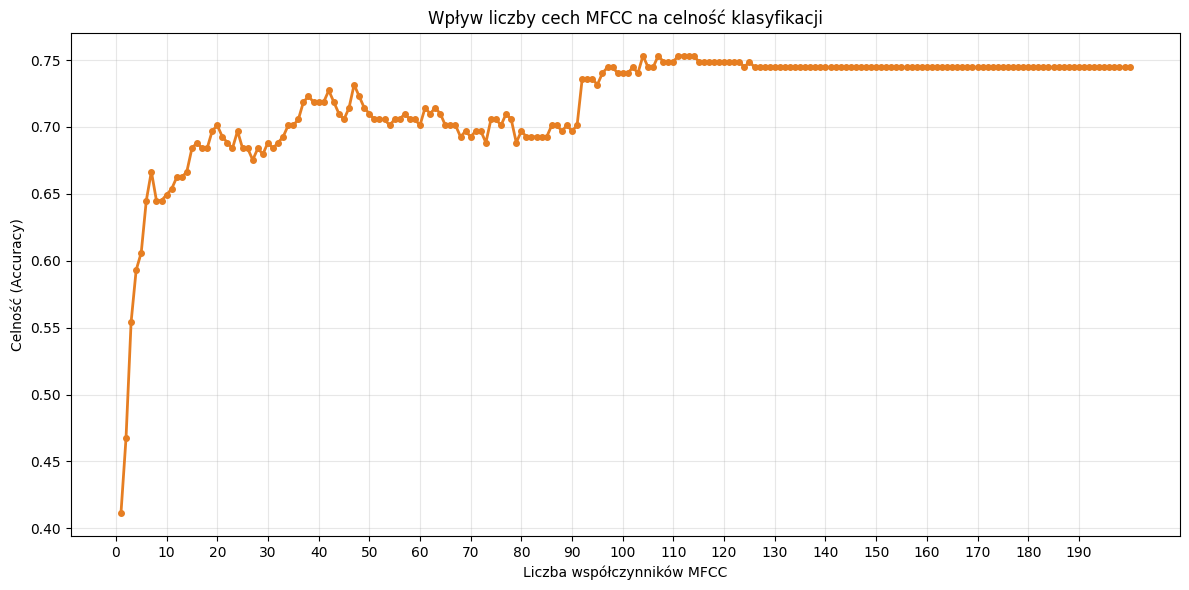

In [2]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# --- Configuration ---
DATA_DIR = '../../dataset/'  # Adjust this path to your dataset location
MAX_MFCC = 200
RANDOM_STATE = 42

def prepare_data(data_dir, max_mfcc=50):
    """
    Loads audio files and extracts the maximum number of MFCCs.
    """
    features = []
    labels = []
    
    print("Loading audio and extracting features...")
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if not os.path.isdir(class_dir):
            continue
            
        for filename in os.listdir(class_dir):
            if filename.endswith(".wav"):
                file_path = os.path.join(class_dir, filename)
                
                # Load audio
                y, sr = librosa.load(file_path, sr=None)
                
                # Extract max number of MFCCs
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=max_mfcc)
                mfcc_mean = np.mean(mfcc.T, axis=0)
                
                features.append(mfcc_mean)
                labels.append(label)
    
    return np.array(features), np.array(labels)

# 1. Load data
features_all, labels_raw = prepare_data(DATA_DIR, MAX_MFCC)

# 2. Encode labels
le = LabelEncoder()
y = le.fit_transform(labels_raw)

# 3. Iterate through different n_mfcc values
accuracies = []
n_range = range(1, MAX_MFCC + 1)

print("Evaluating models for n_mfcc from 1 to 50...")
for n in n_range:
    # Use only the first 'n' coefficients
    X_n = features_all[:, :n]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_n, y, test_size=0.33, random_state=RANDOM_STATE, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train classifier (SVC as in the original notebook)
    clf = SVC(kernel="rbf")
    clf.fit(X_train_scaled, y_train)
    
    # Predict and calculate accuracy
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    if n % 5 == 0:
        print(f"n_mfcc={n}: Accuracy={acc:.4f}")

# 4. Visualization
plt.figure(figsize=(12, 6))
plt.plot(n_range, accuracies, marker='o', color='#e67e22', linewidth=2, markersize=4)
plt.title('Wpływ liczby cech MFCC na celność klasyfikacji')
plt.xlabel('Liczba współczynników MFCC')
plt.ylabel('Celność (Accuracy)')
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(0, MAX_MFCC, 10))
plt.tight_layout()
plt.show()
